In [1]:
from typing import List
from torch_geometric.data import InMemoryDataset
from torch_geometric.distributed.local_graph_store import LocalGraphStore
from torch_geometric.datasets.web_qsp_dataset import *
import torch
import datasets
import time

/home/zaristei/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from raw_qsp_dataset import RawWebQSPDataset

In [3]:
dataset = RawWebQSPDataset(force_reload=True)

Processing...
Done!


In [4]:
dataset.raw_dataset

Dataset({
    features: ['id', 'question', 'answer', 'q_entity', 'a_entity', 'graph', 'choices'],
    num_rows: 4700
})

In [8]:
from large_graph_indexer import LargeGraphIndexer

Test basic collation

In [9]:
indexer = LargeGraphIndexer.from_triplets(dataset.raw_dataset[0]['graph'])

In [10]:
indexer2 = LargeGraphIndexer.from_triplets(dataset.raw_dataset[1]['graph'])

In [11]:
bigger_indexer = LargeGraphIndexer.collate([indexer, indexer2])

In [12]:
assert len(indexer._nodes) + len(indexer2._nodes) - len(indexer._nodes.keys() & indexer2._nodes.keys()) == len(bigger_indexer._nodes)
assert len(indexer._edges) + len(indexer2._edges) - len(indexer._edges.keys() & indexer2._edges.keys()) == len(bigger_indexer._edges)

In [13]:
assert len(set(bigger_indexer._nodes.values())) == len(bigger_indexer._nodes)
assert len(set(bigger_indexer._edges.values())) == len(bigger_indexer._edges)

In [14]:
for node in indexer._nodes.keys():
    assert indexer.node_attr['pid'][indexer._nodes[node]] == node, f'{node} is not {indexer.node_attr["pid"][indexer._nodes[node]]}'

In [15]:
import tqdm
from multiprocessing import Pool

Test collation on entire dataset

In [16]:
def get_next_graph(dataset):
    for ds in dataset:
        yield ds['graph']
graphs = get_next_graph(dataset.raw_dataset)

In [17]:
indexers = []
with Pool(40) as p:
    indexers = list(tqdm.tqdm(p.imap(LargeGraphIndexer.from_triplets, graphs), total=len(dataset.raw_dataset)))

100%|██████████| 4700/4700 [02:57<00:00, 26.41it/s]


In [18]:
start = time.time()
big_indexer = LargeGraphIndexer.collate(indexers)
time.time()-start

15.804845809936523

Naive method, concatenating all the triplets

In [19]:
from itertools import chain

In [20]:
large_graph_dataset = chain.from_iterable(get_next_graph(dataset.raw_dataset))

In [28]:
# This is just for TQDM to work well
total_size = 0
#for g in tqdm.tqdm(get_next_graph(dataset.raw_dataset), total=4700):
#    total_size += len(g)

In [29]:
large_indexer = LargeGraphIndexer.from_triplets(tqdm.tqdm(large_graph_dataset, total=total_size))

19986134it [04:28, 74537.24it/s] 


In [30]:
assert set(large_indexer._nodes) == set(big_indexer._nodes)
assert set(large_indexer._edges) == set(big_indexer._edges)

## Phase I: Indexing Large Graph

In [31]:
node_attributes = list(big_indexer.get_unique_node_features("pid"))
node_attributes = [i.lower() for i in node_attributes]

In [32]:
edge_attributes = list(big_indexer.get_unique_edge_features("r"))
edge_attributes = [i.lower() for i in edge_attributes]

In [33]:
len(node_attributes)

1298306

In [34]:
len(edge_attributes)

6094

In [35]:
from torch_geometric.nn.text import text2embedding, SentenceTransformer

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer("sentence-transformers/all-roberta-large-v1").to(device)
model.eval()

inherit model weights from sentence-transformers/all-roberta-large-v1


SentenceTransformer(
  (bert_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
           

In [37]:
print(device)

cuda


In [38]:
from more_itertools import chunked

In [39]:
nodes_to_process, edges_to_process = len(node_attributes), len(edge_attributes)

In [40]:
BATCH_SIZE = 32

In [41]:
# Indexing graph features
node_embs = []
for nbatch in tqdm.tqdm(chunked(node_attributes, BATCH_SIZE), total=nodes_to_process//BATCH_SIZE):
    node_embs.append(text2embedding(model, device, nbatch, BATCH_SIZE).cpu())
node_embs = torch.cat(node_embs, 0)



40573it [14:15, 47.44it/s]                           


In [42]:
node_embs.shape

torch.Size([1298306, 1024])

In [43]:
big_indexer.add_node_feature(new_feature_name="embs", new_feature_vals=node_embs)

In [44]:
from typing import Iterable
from large_graph_indexer import TripletLike, ordered_set
from torch_geometric.typing import FeatureTensorType
from torch_geometric.data import Data

In [45]:
# Indexing graph features
edge_embs = []
for ebatch in tqdm.tqdm(chunked(edge_attributes, BATCH_SIZE), total=edges_to_process//BATCH_SIZE):
    edge_embs.append(text2embedding(model, device, ebatch).cpu())
edge_embs = torch.cat(edge_embs, 0)


191it [00:03, 50.03it/s]                         


In [46]:
edge_embs.shape

torch.Size([6094, 1024])

In [47]:
big_indexer.add_edge_feature(new_feature_name="embs", new_feature_vals=edge_embs, map_from_feature="r")

In [75]:
def get_features_for_triplets(indexer: LargeGraphIndexer, triplets: Iterable[TripletLike], node_feature_name: str = "embs", edge_feature_name: str = "embs") -> Data:
    nodes = {}
    edges = []
    edge_index = []

    for h, r, t in triplets:
        if h not in nodes:
            nodes[h] = len(nodes)
        if t not in nodes:
            nodes[t] = len(nodes)
         
        edges.append((h, r, t))
        edge_index.append([nodes[h], nodes[t]])

    node_keys = list(nodes.keys())
    edge_keys = ordered_set(edges)
    
    node_feats: Iterable[FeatureTensorType] = indexer.get_node_features(feature_name=node_feature_name, pids=node_keys)
    edge_feats: Iterable[FeatureTensorType] = indexer.get_edge_features(feature_name=edge_feature_name, pids=edge_keys)

    x=torch.stack(node_feats, 0)
    edge_attr=torch.stack(edge_feats, 0)
    edge_index=torch.t(torch.LongTensor(edge_index))
    return Data(x=x, edge_index=edge_index,edge_attr=edge_attr,num_nodes=len(nodes))



In [76]:
first_10_trips = dataset.raw_dataset[:10]['graph']

In [77]:
#TODO: Parallelize
first_10 = [get_features_for_triplets(big_indexer, trip_lst) for trip_lst in tqdm.tqdm(first_10_trips)]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:31<00:00,  9.10s/it]


In [59]:
# Grab the first few samples from the old ds to test with LargeGraphIndexer
old_dataset = RawWebQSPDataset(force_reload=True, with_process=True, limit=10)

Processing...


inherit model weights from sentence-transformers/all-roberta-large-v1
Encoding graphs...


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]
Done!


In [80]:
old_dataset[1]

Data(x=[1251, 1024], edge_index=[2, 4135], edge_attr=[4135, 1024], num_nodes=1251)

In [84]:
first_10[1]

Data(x=[1253, 1024], edge_index=[2, 4135], edge_attr=[4110, 1024], num_nodes=1253)

In [83]:
old_dataset[1].x

tensor([[-0.0125, -0.0546,  0.0086,  ...,  0.0134, -0.0341, -0.0751],
        [-0.0307,  0.0144, -0.0046,  ..., -0.0031,  0.0074,  0.0622],
        [ 0.0179, -0.0098, -0.0052,  ...,  0.0363,  0.0285, -0.0096],
        ...,
        [-0.0209, -0.0395,  0.0079,  ...,  0.0088, -0.0173, -0.0367],
        [ 0.0146, -0.0179,  0.0028,  ...,  0.0038,  0.0451, -0.0351],
        [ 0.0216,  0.0204,  0.0138,  ...,  0.0175,  0.0476,  0.0351]])

In [90]:
import matplotlib.pyplot as plt

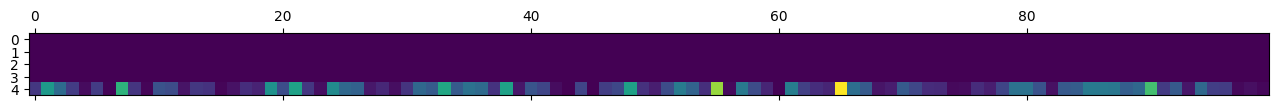

In [101]:
from_=85
to=90
plt.matshow((first_10[0].x[from_:to,:100]-old_dataset[0].x[from_:to,:100]).abs())
plt.show()

In [102]:
dataset.raw_dataset[0]['graph'][85:90]

[['Terence Dudley', 'music.artist.genre', 'Reggae'],
 ['Kylie Minogue', 'people.person.profession', 'Actor'],
 ['Adrienne Bailon', 'music.artist.genre', 'Pop music'],
 ['Katy Perry', 'music.artist.genre', 'Electronic music'],
 ['Dany Brillant', 'people.person.gender', 'Male']]

In [106]:
old_dataset.raw_dataset[0]['graph'][85:90]

[['Terence Dudley', 'music.artist.genre', 'Reggae'],
 ['Kylie Minogue', 'people.person.profession', 'Actor'],
 ['Adrienne Bailon', 'music.artist.genre', 'Pop music'],
 ['Katy Perry', 'music.artist.genre', 'Electronic music'],
 ['Dany Brillant', 'people.person.gender', 'Male']]

In [107]:
len(old_dataset.raw_dataset[0]['graph'])

9088

In [108]:
len(dataset.raw_dataset[0]['graph'])

9088